In [4]:
#!pip install scikit-dsp-comm

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square
from sk_dsp_comm import digitalcom as dc
from sk_dsp_comm import sigsys as ss

In [6]:
def generar_cuadrada(frecuencia, duracion, Muestras, duty_cycle):
    
    t = np.linspace(0, duracion, Muestras, endpoint=False)
    signal_square = square(2 * np.pi * frecuencia * t, duty=duty_cycle)

    # Ajustar el ancho del pulso
    signal_square = 0.5 * (signal_square + 1)  # Escalar y desplazar para ajustar el ancho

    return t, signal_square

#SamplingRate = '{:.2e}'.format(150e6)
Muestras = 100000

print(f"SamplingRate = {Muestras}")

c = 2.988e8             #Velocidad de la luz
Dmin = 2                #Distancia minima que detecta el radar
Dmax = 10               #Distancia maxima que detecta el radar


PRI = (Dmax*2)/c        #Frecuenca de transmision de pulsos del radar [s]
PRF = 1/PRI             #Periodo de transmision de pulsos de radar    [s]
PL = (Dmin*2)/c         #Ancho del pulso a transmitir                 [s]
duracion = PRI * 10
duty_cycle = PL / PRI

# Generar señal cuadrada con parámetros variables
t, signal_square = generar_cuadrada(PRF, duracion, Muestras, duty_cycle)

print(f"Pulse Repetition Interval: PRI = {'{:.2e}'.format(PRI)}\nPulse Repetition Frecuency: PRF = {'{:.2e}'.format(PRF)}\nPulse Length: PL = {'{:.2e}'.format(PL)} - {duty_cycle}")

SamplingRate = 100000
Pulse Repetition Interval: PRI = 6.69e-08
Pulse Repetition Frecuency: PRF = 1.49e+07
Pulse Length: PL = 1.34e-08 - 0.2


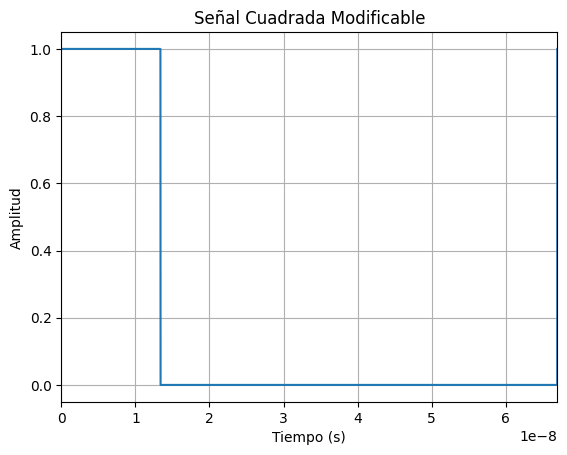

In [7]:
# Graficar
plt.plot(t, signal_square)
plt.title('Señal Cuadrada Modificable')
plt.xlabel('Tiempo (s)')
plt.xlim(0, PRI)
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

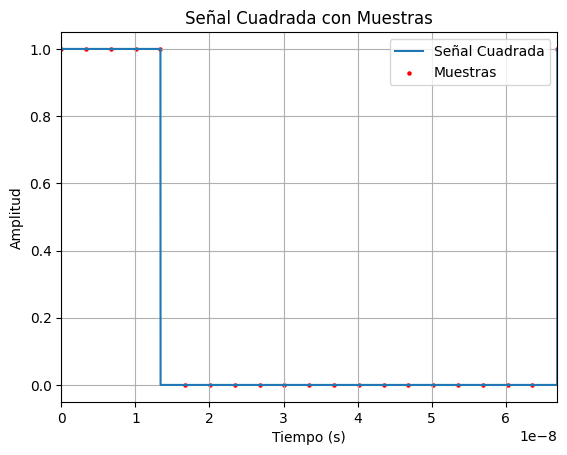

In [8]:
Fsampling = 20*PRF               # Frecuencia de muestreo. samplingRate >= 2 * PRF (frecuencia maxima de la señal)
Tsampling = 1 / Fsampling


# Elegir puntos de muestreo. samplingRateg >= 1/(2*PRF)
puntos_de_muestreo = np.arange(0, duracion, Tsampling)
Nmuestas = np.interp(puntos_de_muestreo, t, signal_square)

for m in range(len(Nmuestas)):
    if Nmuestas[m] > 0.0:
        Nmuestas[m] = 1
    else:
        Nmuestas[m] = 0

# Graficar la señal cuadrada y las muestras
plt.plot(t, signal_square, label='Señal Cuadrada')
plt.scatter(puntos_de_muestreo, Nmuestas, s=5 ,color='red', label='Muestras')
plt.title('Señal Cuadrada con Muestras')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim((0, PRI))
plt.legend()
plt.grid(True)
plt.show()

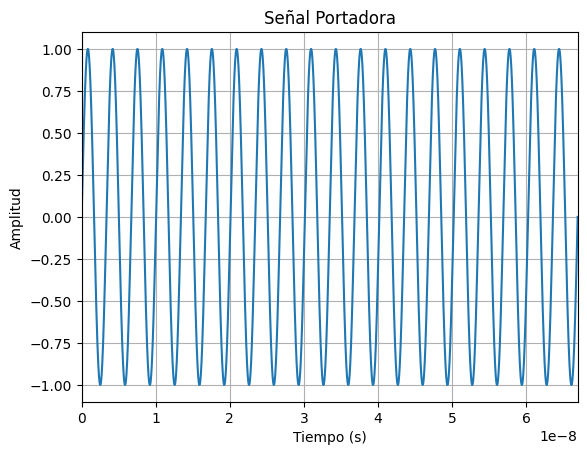

In [9]:
# Señal Portadora

# Parámetros de la señal
A = 1.0                 # Amplitud
f = PRF * 20            # Frecuencia de la señal (para una longitud de onda de 1 micrómetro)
T = 1/f
duration = PRI * 10     # Duración de la señal en segundos

# Crear el vector de tiempo
ts = np.linspace(0, duration, Muestras, endpoint=False)

# Crear la señal sinusoidal
Tx = A * np.sin(2 * np.pi * f * t)

# Graficar la señal
plt.plot(ts, Tx)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal Portadora')
plt.xlim(0, PRI)
plt.grid(True)
plt.show()

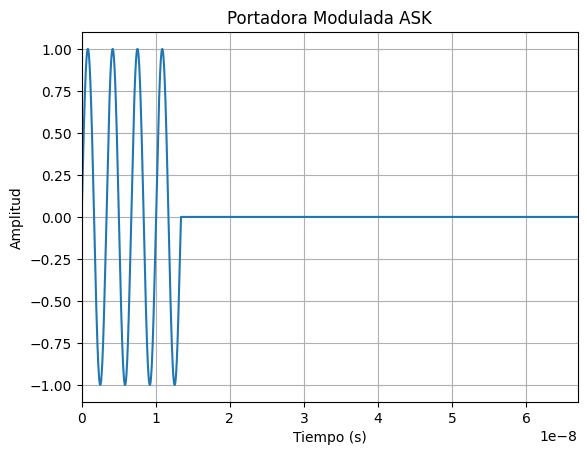

In [10]:
# Simulacion Señal a Transmitir

Rx = signal_square * Tx

# Graficar la señal
plt.plot(t, Rx)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Portadora Modulada ASK')
plt.xlim(0, PRI)
plt.grid(True)
plt.show()

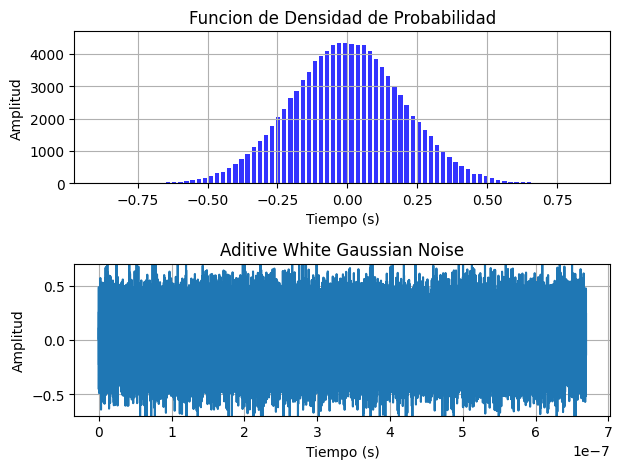

Tamaño de las muestas: 100000


In [18]:
#Modelado ruido AWGN(Additive White Gaussian Noise)

AWGN = np.random.normal(loc=0,scale=0.2, size=len(Rx))


# Graficar del histograma
plt.subplot(2, 1, 1)  # Subplot 2: 2 filas, 1 columna, segundo subplot
plt.hist(AWGN, rwidth=0.7 ,bins=80, color='blue', alpha=0.8)
# Personalizar los ticks del eje x
#plt.xticks(np.arange(0, 50000, 10000))  # Especifica los valores de los ticks manualmente
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.ylim(0, 4700)
plt.title('Funcion de Densidad de Probabilidad')
plt.grid(True)

# Graficar la señal
plt.subplot(2, 1, 2)  # Subplot 2: 2 filas, 1 columna, segundo subplot
plt.plot(t, AWGN)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.ylim(-0.7, 0.7)
plt.title('Aditive White Gaussian Noise')
plt.grid(True)

plt.tight_layout()  # Ajustar automáticamente los subplots
plt.show()

print(f"Tamaño de las muestas: {len(Rx)}")

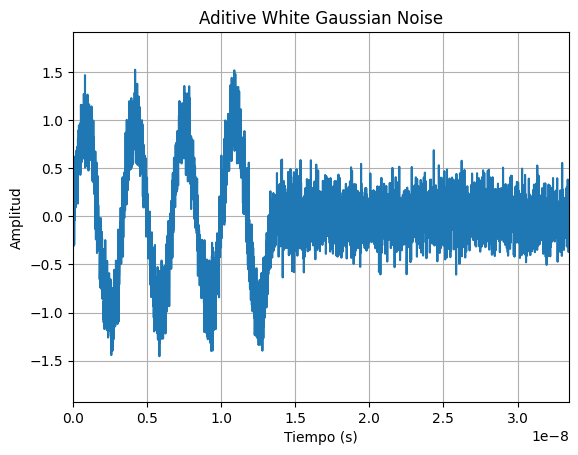

In [24]:
# Señal que entra al canal

S_finalN = Rx + AWGN

# Graficar la señal
plt.plot(t, S_finalN)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Aditive White Gaussian Noise')
plt.xlim(0, PRI/2)
plt.grid(True)
plt.show()